In [2]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 53.9 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Dataset Loaded Successfully
   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Label distribution:
 label
0    4825
1     747
Name: count, dtype: int64

✅ Sample tokenized message:
0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
Name: tokens, dtype: object

Training Word2Vec model...

Training Logistic Regression model...

Training Naive Bayes model...

========== 🧾 MODEL EVALUATION ==========

📘 Logistic Regression Results:
Accuracy: 0.9175
              precision    recall  f1-score   support

         Ham       0.98      0.93      0.95       966
        Spam    

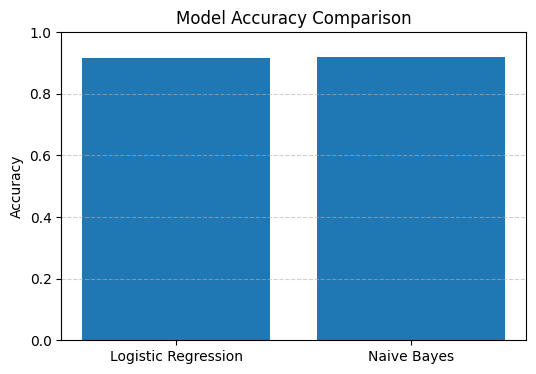


========== 🔍 LIVE MESSAGE PREDICTIONS ==========

Message: Congratulations! You've won a free iPhone. Click this link immediately to claim your prize.
Logistic Regression Prediction → SPAM
Naive Bayes Prediction → SPAM
------------------------------------------------------------
Message: Hey, can we reschedule the meeting to tomorrow afternoon?
Logistic Regression Prediction → HAM
Naive Bayes Prediction → HAM
------------------------------------------------------------
Message: Your account has been suspended. Please verify your details immediately.
Logistic Regression Prediction → SPAM
Naive Bayes Prediction → SPAM
------------------------------------------------------------
Message: Let's catch up for coffee tomorrow!
Logistic Regression Prediction → HAM
Naive Bayes Prediction → HAM
------------------------------------------------------------


In [7]:
# ============================================
# 📘 SPAM MESSAGE DETECTION USING WORD2VEC WITH
# LOGISTIC REGRESSION & NAIVE BAYES COMPARISON
# ============================================

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# -------------------------------
# Download NLTK dependencies
# -------------------------------
nltk.download('punkt')
nltk.download('punkt_tab')     # ✅ Fix for LookupError
nltk.download('stopwords')

# -------------------------------
# LOAD AND CLEAN DATA
# -------------------------------
df = pd.read_csv("/content/spam.csv", encoding='latin-1')[['Category', 'Message']]
df.columns = ['label', 'text']

# Normalize and encode labels
df['label'] = df['label'].str.lower().map({'ham': 0, 'spam': 1})
df.dropna(subset=['label', 'text'], inplace=True)
df['label'] = df['label'].astype(int)

print("✅ Dataset Loaded Successfully")
print(df.head())
print("\nLabel distribution:\n", df['label'].value_counts())

# -------------------------------
# TEXT PREPROCESSING
# -------------------------------
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return tokens

df['tokens'] = df['text'].apply(preprocess_text)

print("\n✅ Sample tokenized message:")
print(df['tokens'].head(3))

# -------------------------------
# TRAIN WORD2VEC MODEL
# -------------------------------
print("\nTraining Word2Vec model...")
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4, sg=1)

# Function to get averaged word vector
def get_vector(tokens):
    vectors = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(100)
    else:
        return np.mean(vectors, axis=0)

df['vector'] = df['tokens'].apply(get_vector)

# -------------------------------
# SPLIT DATA
# -------------------------------
X = np.vstack(df['vector'].values)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# TRAIN LOGISTIC REGRESSION
# -------------------------------
print("\nTraining Logistic Regression model...")
log_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)

# -------------------------------
# TRAIN NAIVE BAYES
# -------------------------------
print("\nTraining Naive Bayes model...")
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

# -------------------------------
# EVALUATION
# -------------------------------
print("\n========== 🧾 MODEL EVALUATION ==========\n")

print("📘 Logistic Regression Results:")
print("Accuracy:", round(acc_log, 4))
print(classification_report(y_test, y_pred_log, target_names=['Ham', 'Spam']))

print("📗 Naive Bayes Results:")
print("Accuracy:", round(acc_nb, 4))
print(classification_report(y_test, y_pred_nb, target_names=['Ham', 'Spam']))

# -------------------------------
# DETERMINE BEST MODEL
# -------------------------------
if acc_log > acc_nb:
    best_model = "Logistic Regression"
    best_accuracy = acc_log
else:
    best_model = "Naive Bayes"
    best_accuracy = acc_nb

print("\n✅ The model with the highest accuracy is:", best_model)
print(f"🎯 Best Accuracy: {best_accuracy:.4f}")

# -------------------------------
# PLOT ACCURACY COMPARISON
# -------------------------------
plt.figure(figsize=(6,4))
models = ['Logistic Regression', 'Naive Bayes']
accuracies = [acc_log, acc_nb]
plt.bar(models, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# -------------------------------
# LIVE PREDICTION FUNCTION
# -------------------------------
def predict_message(msg, model, model_name="Model"):
    tokens = preprocess_text(msg)
    vec = get_vector(tokens).reshape(1, -1)
    pred = model.predict(vec)[0]
    result = "SPAM" if pred == 1 else "HAM"
    print(f"{model_name} Prediction → {result}")

# -------------------------------
# TEST ON CUSTOM MESSAGES
# -------------------------------
test_messages = [
    "Congratulations! You've won a free iPhone. Click this link immediately to claim your prize.",
    "Hey, can we reschedule the meeting to tomorrow afternoon?",
    "Your account has been suspended. Please verify your details immediately.",
    "Let's catch up for coffee tomorrow!"
]

print("\n========== 🔍 LIVE MESSAGE PREDICTIONS ==========\n")
for msg in test_messages:
    print(f"Message: {msg}")
    predict_message(msg, log_model, "Logistic Regression")
    predict_message(msg, nb_model, "Naive Bayes")
    print("-" * 60)
